
# 1. Preparation and Overview

## 1.1 Business Understanding


Austin Animal Center is the largest no-kill shelter in the United States and provides shelter to more than 16,000 animals each year. As a no-kill shelter they refuse to euthanize any animal unless the animal has a terminal medical issue and is in pain or if the animal is a danger to the public or to the shelter staff. Although the shelter’s primary goal is to find ‘forever homes’ for each and every animal that comes through their doors, many animals end up staying in the shelter for a long time if they are not considered as desirable for adoption as other animals. In addition to adopting out animals, the Austin Animal Center partners with various other rescues and animal sanctuaries to try to find homes for their animals.

The average annual cost per animal at the Austin Animal Center is approximately $715 [3] and with many animals staying at the facility for long periods of time, some for several years, the cost can add up quickly. The shelter has fixed financial support via legislation to cover costs for staffing the shelters and a few grants to cover veterinary staff and services, but the shelter primarily relies on donations to provide for food, bedding and toys for the animals. The shelter must try to minimize costs associated with each animal and try to have the animals leave the shelter through adoption or transfer to a sanctuary as quickly as possible.

The Austin Animal Center keeps track of each animal that comes through their doors and keeps a record of the animal’s outcome; that is whether they were adopted, transferred to a partner shelter or sanctuary or one of many other outcomes. If the shelter could predict an animal’s outcome based on the animal’s characteristics, they could be much more efficient with having animals leave the shelter by knowing which animals they should be able to adopt out and which animals they should transfer to other shelters or sanctuaries. This added efficiency would result in the shelter’s ability to take in more animals which in return would lower the average cost per animal.

This lab examines the Austin Animal Center animal outcome data set to specifically look at cats and the outcome of each cat and attempts to build an accurate model of predicting the outcome. If accurate, this model could serve the Austin Animal Center as well as other cities that are looking at issuing a no-kill ordinance for their shelters.

## 1.2 Data Preparation

In [2]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [3]:
# import data
shelter_outcomes = pd.read_csv("aac_shelter_outcomes.csv")
# filter animal type for just cats
cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'animal_type', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
8,domestic shorthair,blue tabby,59,6,16,0,8,14,3,18,3,None,white,False,female,1,adoption_unknown
9,domestic shorthair,white,95,3,26,2,6,29,6,17,2,None,black,True,female,1,adoption_offsite
10,domestic mediumhair,black,366,3,27,2,3,28,4,14,1,None,white,True,female,1,return-to-owner_unknown
17,domestic shorthair,black,24,12,16,0,1,9,3,19,1,None,white,False,male,1,transfer_partner


Not all information included in this data set is necessary to the targeted prediction of outcome type. Some animals that were adopted were returned to the shelter as runaways before being returned to their owners. These instances have no impact on trying to predict outcome and will be removed from the data set.



## 1.3 Data Description

In [4]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int32
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



In [5]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


transfer_partner           9486
adoption_unknown           9264
adoption_foster            3357
transfer_scrp              3211
return-to-owner_unknown    1431
euthanasia_suffering       1304
transfer_snr                625
died_in-kennel              208
died_in-foster              138
adoption_offsite            110
euthanasia_rabies-risk       61
euthanasia_medical           56
rto-adopt_unknown            33
died_unknown                 17
died_at-vet                  17
euthanasia_at-vet            16
disposal_unknown             16
died_enroute                 15
missing_in-foster            14
euthanasia_unknown           11
died_in-surgery               8
missing_in-kennel             7
missing_unknown               5
euthanasia_aggressive         4
unknown_unknown               3
missing_possible-theft        2
transfer_barn                 1
adoption_barn                 1
euthanasia_underage           1
Name: outcome, dtype: int64


Each feature has a different count, a low count per feature decrease the accuracy and the efficiency of the logistic regression method used, so all features with low count was not taken into account in traning the classfier

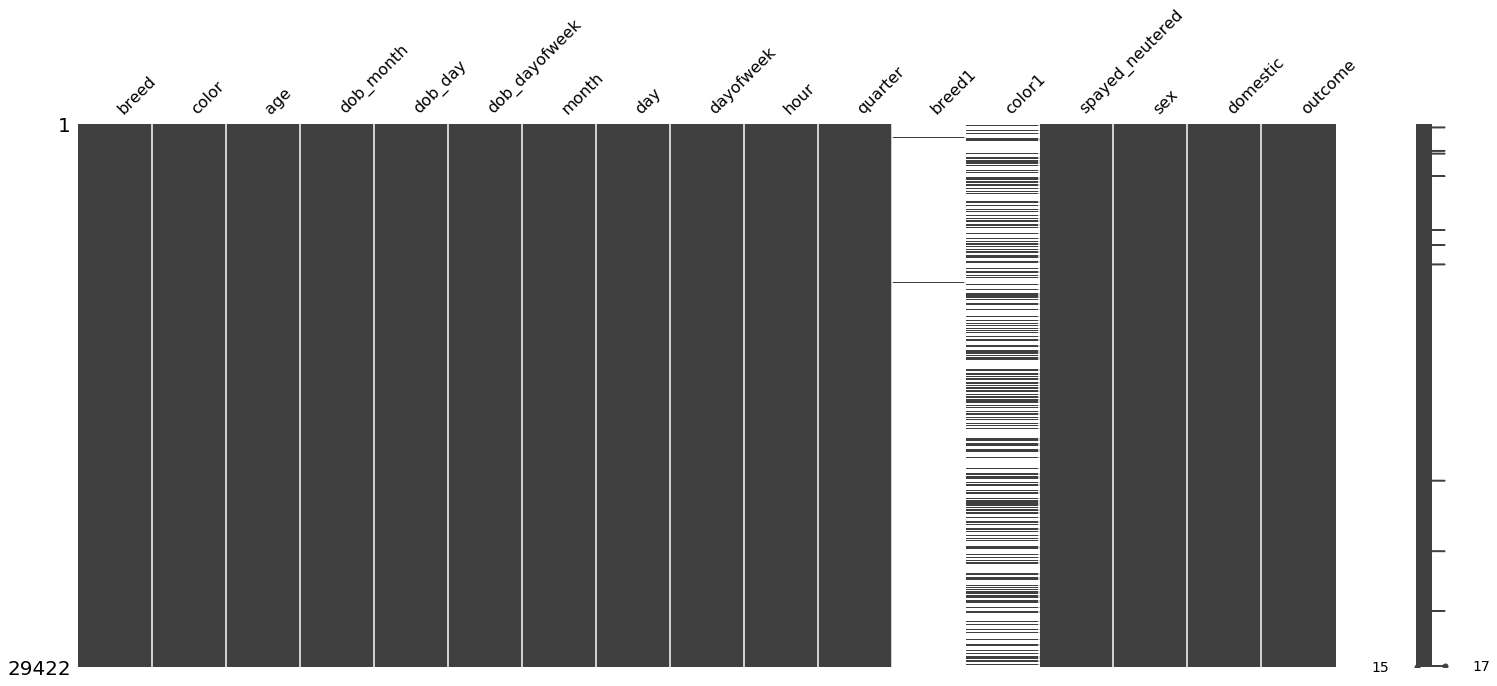

In [6]:
# examine missing data
msno.matrix(cats)


Since the missing data shows that breed1 will have little impact on the prediction since there are only two records that have a value, it will be removed from the data set. The missing data in color1 should be handled when one hot encoding is performed on it.


## 1.4 One hot encoding of data and splitting into training and testing sets

In [7]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex'])
cats_ohe.head()
out_t={'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 1, 'euthanasia_at-vet' : 2, 'adoption_foster' : 3, 'died_in-foster' : 0, 'transfer_scrp' : 4, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 0, 'missing_in-foster' : 0, 'adoption_offsite' : 0, 'adoption_unknown' :5,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}
#output is converted from string to catogries 0 to 5 represent each output
# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
y_train = [out_t[item] for item in y_train]
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
8    59          6       16              0      8   14          3    18   
9    95          3       26              2      6   29          6    17   
10  366          3       27              2      3   28          4    14   
17   24         12       16              0      1    9          3    19   

    quarter  domestic  ... color1_tortie point  color1_tricolor  color1_white  \
0         3         1  ...                   0                0             0   
8         3         1  ...                   0                0             1   
9         2         1  ...                   0                0             0   
10        1         1  ...                   0                0             1   
17        1         1  ...                   0                0             1   

    color1_yellow  spayed_neutered_False  spayed_neutered_True


One hot encoding is used for the cat breed, color, spayed/neutered and sex attributes to convert the categorical variables into a form that should play nicer with logistic regression. Although spayed_neutered and sex are essentially boolean attributes, they had to be converted because there were many unknown values in each.

The data is split with an 80/20 train/test ratio using the train_test_split function in the cross validation functions in Skikit Learn's cross validation package. Although this was an easy method to split the data into training and test sets, it was not a good way to split the data for this dataset. As shown above, the target distribution is skewed and some targets have very few instances. It would have been better to select an 80/20 ratio for each class.

(23537, 140)
(23537,)


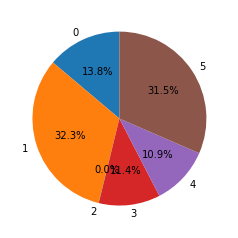

In [8]:
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
print(x_train_ar.shape)
print(y_target_ar.shape)
unique, counts = np.unique(y_target_ar, return_counts=True)
np.asarray((unique, counts))
plt.pie(np.asarray(( counts)), labels=np.unique(y_target_ar), startangle=90, autopct='%.1f%%')
plt.show()

# Evaluation 

The metric we will use to determine the performance of our model will be the macro-averaged F1 score. We are using macro-averaging instead of micro since we have a class imbalance problem. The number of instances for each class varies quite greatly and we want to use a metric that will weigh the scores equally for each class.

We are using F1 as we care both about precision and recall. The goal of the Austin Animal Center is to determine in advance how likely an animal is to be adopted, transferred, or if it will never be either. In any case, mislabeling has dire consequences. If we classify an animal as likely adoptable but are incorrect, it could have financial consequences. If we incorrectly ignore an animal because we think it wouldn't be adopted, we missed out on providing a home for a pet in need.

In [10]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# macro-averaged f1

macro_avg_f1_scorer = make_scorer(score_func=f1_score,
                                 pos_label=1,
                                 greater_is_better=True,
                                 average='micro')

## Stratified k-fold Cross Validation
To break up our data into training and test sets, we have chosen to implement k-fold cross validation. Because our data has varying numbers of instances for each class, stratified k-fold cross validation will allow us to train on sections of data that retain the same proportions of classes as the overall dataset.

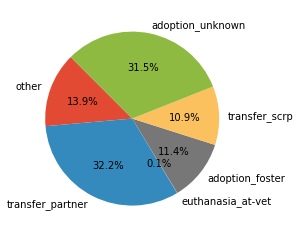

Number of instances of other : 4088
Number of instances of transfer_partner : 9486
Number of instances of euthanasia_at-vet : 16
Number of instances of adoption_foster : 3357
Number of instances of transfer_scrp : 3211
Number of instances of adoption_unknown : 9264


In [21]:
from matplotlib import pyplot as plt
import copy
%matplotlib inline


X = copy.deepcopy(cats_ohe)
X.drop(columns=['outcome'], inplace=True)
y = copy.deepcopy(cats_ohe['outcome'])
y = [out_t[item] for item in y]

target_labels = {'other': 0}
for key in out_t:
    if out_t[key] != 0:
        target_labels[key] = out_t[key]
        
#print (target_labels)

unique, counts = np.unique(y, return_counts=True)

np.asarray((unique, counts)).T


plt.style.use('ggplot')

plt.pie(counts, labels=target_labels, startangle=135, autopct='%.1f%%')
plt.show()

for lbl in target_labels:
    print('Number of instances of', lbl, ':', counts[target_labels[lbl]])




In [12]:
x_ar=X.values
y_ar=np.asarray(y)
x_ar = StandardScaler().fit(x_ar).transform(x_ar)

print(x_ar)
print(y_ar)

[[-0.52745758  0.28709801 -0.97799631 ... -0.93138104  1.10652135
  -0.30659201]
 [-0.48270876 -0.06728182  0.04358739 ...  1.07367442 -0.90373312
  -0.30659201]
 [-0.44609608 -1.13042131  1.17868038 ...  1.07367442 -0.90373312
  -0.30659201]
 ...
 [-0.16946698 -1.83918097  1.63271758 ... -0.93138104  1.10652135
  -0.30659201]
 [-0.35151334  0.28709801  1.40569898 ...  1.07367442 -0.90373312
  -0.30659201]
 [-0.35151334  0.28709801  1.40569898 ... -0.93138104  1.10652135
  -0.30659201]]
[1 5 0 ... 1 5 5]


Wall time: 1min 27s


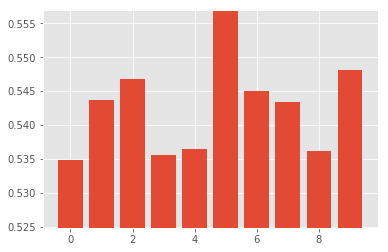

In [22]:
%%time
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
# select cross validation
sss=StratifiedShuffleSplit(n_splits=10, random_state=1)



# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=x_ar,
                                    y=y_ar,
                                    cv=sss,
                                    scoring=macro_avg_f1_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

In [23]:
#plotting function for use in next question
# takes input 'test_scores', axis labels, and an x-axis label
def plot_filled(test_scores,train_x_axis, xlabel=''):
    
    test_mean = np.percentile(test_scores,50, axis=1)
    test_max = np.percentile(test_scores,95, axis=1) 
    test_min = np.percentile(test_scores,5, axis=1) 

    plt.plot(train_x_axis, test_mean,
             color='blue', linestyle='--',
             marker='s', markersize=5,
             label='validation set')

    plt.fill_between(train_x_axis,
                     test_min,
                     test_max,
                     alpha=0.15, color='blue')

    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Evaluation Criterion')
    plt.legend(loc='lower right')
    plt.tight_layout()

Wall time: 10min 40s


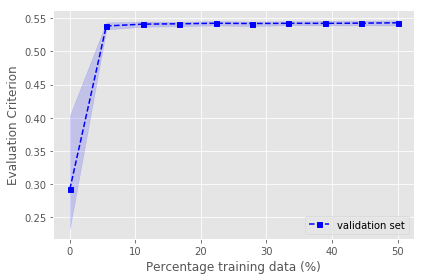

In [24]:
%%time
test_scores = []
train_sizes=np.linspace(5e-4,5e-1,10)

for size in train_sizes:
    sss = StratifiedShuffleSplit(n_splits=100,
                                train_size = size,
                                test_size = 1-size,
                               )
    test_scores.append(cross_val_score(estimator=clf,X=X,y=y,cv=sss,scoring=macro_avg_f1_scorer))

plot_filled(np.array(test_scores), train_sizes*100, 'Percentage training data (%)')

# Modeling 

# Exceptional Work 

In [1619]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,phi='sig',n_ner=2,cf='quad'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.phi=phi
        self.n_ner=n_ner
        self.cf=cf
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        #W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        #W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        #W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        #W2_num_elems = (self.n_hidden + 1)*self.n_output_
        #W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        #W2 = W2.reshape(self.n_output_, self.n_hidden + 1)

        for i in range(self.n_ner):
         if i==0:
          vars()["W" + str(i + 1) +"_num_elems"] = (self.n_features_ + 1)*self.n_hidden
          vars()["W" + str(i + 1)] = np.random.uniform(-1.0, 1.0,size=vars()["W" + str(i + 1) +"_num_elems"])
          vars()["W" + str(i + 1)] = vars()["W" + str(i+1)].reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W 

         if i>0:
          vars()["W" + str(i + 1)+"_num_elems"] = (self.n_hidden + 1)*self.n_hidden
          vars()["W" + str(i + 1)] = np.random.uniform(-1.0, 1.0,size=vars()["W" + str(i + 1)+"_num_elems"])
          vars()["W" + str(i + 1)] = vars()["W" + str(i+1)].reshape(self.n_hidden, self.n_hidden + 1) # reshape to be W 
      
         if i==(self.n_ner-1):
          vars()["W" + str(i + 1)+"_num_elems"] = (self.n_hidden + 1)*self.n_output_  
          vars()["W" + str(i + 1)] = np.random.uniform(-1.0, 1.0,size=vars()["W" + str(i + 1)+"_num_elems"])
          vars()["W" + str(i + 1)] = vars()["W" + str(i+1)].reshape(self.n_output_, self.n_hidden + 1)

        return vars()
    
    @staticmethod
    def _sigmoid(z,phi):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        if phi=='sig': 
         return expit(z)
        if phi=='lin': 
         return z
        if phi=='silu': 
         return expit(z)*z
        if phi=='relu': 
         bol= z>=0  
         #z=bol*z
         return np.maximum(0,z.copy())
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W,n):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        W_sum=0
        for i in range(n):
         W_sum=np.mean(W['W'+str(i+1)][:, 1:] ** 2)+W_sum
            
        sqr=np.sqrt(W_sum)
        return (lambda_/2.0) *sqr
    
    def _cost(self,Al,Y_enc,W):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-Al)**2)
        L2_term = self._L2_reg(self.l2_C, W,self.n_ner)
        return cost + L2_term
    
    def _feedforward(self, X, W, n_ner):
        """Compute feedforward step
        """ 
    # for i in range(5):
     #   n = 1
      #  globals()["A" + str(i + 1)] = a + b
       # print(globals()["Temp" + str(i + 1)])
        #n = n + 1
        #A1 = self._add_bias_unit(X, how='column')
        #A1 = A1.T
       # Z1 = W1 @ A1
        #A2 = self._sigmoid(Z1,self.phi)
        #A2 = self._add_bias_unit(A2, how='row')
        #Z2 = W2 @ A2
        #A3 = self._sigmoid(Z2,'sig')  nl=3
  
        for i in range(self.n_ner+1):
         if i==0:   
          vars()["A"+str(i+1)]=self._add_bias_unit(X, how='column')
          vars()["A"+str(i+1)]=vars()["A"+str(i+1)].T
          vars()["Z"+str(i+1)]=W["W"+str(i+1)] @ vars()["A"+str(i+1)]
          #print("A"+str(i+1))
          #print(vars()["A"+str(i+1)])
         if (i>0) and i<(self.n_ner):
          vars()["A"+str(i+1)]=self._sigmoid(vars()["Z"+str(i)],self.phi)
          vars()["A"+str(i+1)]=self._add_bias_unit(vars()["A"+str(i+1)], how='row')
          vars()["Z"+str(i+1)]=W["W"+str(i+1)]@vars()["A"+str(i+1)]
          #print("A"+str(i+1))
          #print(vars()["A"+str(i+1)])
         if i==(self.n_ner):
          vars()["A"+str(i+1)]=self._sigmoid(vars()["Z"+str(i)],'sig')
          #print("A"+str(i+1))
          #print(vars()["A"+str(i+1)])
        
        return vars()
    def _div(b,A_,phi):
     
        if phi=='sig':   
         return A_*(1-A_)
        if phi=='lin':     
         return 1
        if phi=='silu':
         return (expit(A_)*A_)+(expit(A_)*(1-expit(A_)*A_))
        if phi=='relu': 
         bol= A_>=0   
         return 1  
    
    def _get_gradient(self, F, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        #Z1_with_bias = self._add_bias_unit(Z1,how='row')
        #Z2_with_bias = self._add_bias_unit(Z2,how='row')
        #V2 = -2*(Y_enc-A3)*self._div(A3,self.phi) # last layer sensitivity
        #V1 = self._div(A2,self.phi)*(W2.T @ V2) # back prop the sensitivity 
    
        #grad2 = V2 @ A2.T # no bias on final layer
        #grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        if self.cf=="quad": 
         vars()['V'+str(self.n_ner)] = -2*(Y_enc-F["A"+str(self.n_ner+1)])*self._div(F["A"+str(self.n_ner+1)],'sig')
         #if self.phi=='relu': 
         # vars()['V'+str(self.n_ner)][F["Z"+str(self.n_ner)]<=0] = 0 
         
       
        if self.cf=="ce": 
         vars()['V'+str(self.n_ner)] = -2*(Y_enc-F["A"+str(self.n_ner+1)])
         
        vars()['grad'+str(self.n_ner)] = vars()['V'+str(self.n_ner)] @ F["A"+str(self.n_ner)].T    

        vars()['grad'+str(self.n_ner)][:, 1:] += W["W"+str(self.n_ner)][:, 1:] * self.l2_C
        
        for i in range(self.n_ner-1):
         l=self.n_ner-1-i # l=4-->1
         if l==self.n_ner-1:
          
          vars()["Z"+str(l)+"_with_bias"] = self._add_bias_unit(F["Z"+str(l)],how='row')
          
          vars()['V'+str(l)] = self._div(F["A"+str(l+1)],self.phi)*(W["W"+str(l+1)].T @ vars()['V'+str(l+1)])
          if self.phi=='relu':
           vars()['V'+str(l)][vars()["Z"+str(l)+"_with_bias"]<=0] = 0
         if l!=self.n_ner-1:
          
          vars()["Z"+str(l)+"_with_bias"] = self._add_bias_unit(F["Z"+str(l)],how='row')
          vars()['V'+str(l)] = self._div(F["A"+str(l+1)],self.phi)*(W["W"+str(l+1)].T @ vars()['V'+str(l+1)][1:, :]) 
          if self.phi=='relu':
           vars()['V'+str(l)][vars()["Z"+str(l)+"_with_bias"]<=0] = 0
         
        
         vars()['grad'+str(l)]=vars()['V'+str(l)][1:,:]  @ F["A"+str(l)].T
      
    
         vars()['grad'+str(l)][:, 1:] += W["W"+str(l)][:, 1:] * self.l2_C
        # regularize weights that are not bias terms
        #grad1[:, 1:] += W1[:, 1:] * self.l2_C
        #grad2[:, 1:] += W2[:, 1:] * self.l2_C
        
        
        return vars()
    
    def predict(self, X):
        """Predict class labels"""
        p = self._feedforward(X, self.W,self.n_ner)
        #print(p["A"+str(self.n_ner+1)])
        
        y_pred = np.argmax(p["A"+str(self.n_ner+1)], axis=0)
        return y_pred

In [1595]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
      
          #self.vars()["W" + str(i + 1)]= self._initialize_weights(i)
        self.W=self._initialize_weights()
        
          #print(self.W['W1'])
        for i in range(self.n_ner):
         vars()["delta_W"+str(i + 1)+"_prev"] = np.zeros(self.W["W" + str(i + 1)].shape)
        #delta_W2_prev = np.zeros(self.W[2].shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
             
                F = self._feedforward(X_data[idx],self.W,self.n_ner)
                                                      
                              # F["A"+str(self.n_ner+1)]                     
                
                cost = self._cost(F["A"+str(self.n_ner+1)],Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad= self._get_gradient(F= F, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W=self.W)
                
                # momentum calculations
                for i in range(self.n_ner):
                 #delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                 #self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                 #self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                 #delta_W1_prev, delta_W2_prev = delta_W1, delta_W2
                 vars()["delta_W"+str(i + 1)] = self.eta * grad["grad"+str(i + 1)]
                 self.W["W"+str(i + 1)] -=(vars()["delta_W"+str(i + 1)]+ (self.alpha * vars()["delta_W"+str(i + 1)+"_prev"]))
                 vars()["delta_W"+str(i + 1)+"_prev"]=vars()["delta_W"+str(i + 1)]   
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self

In [1602]:
%%time
params = dict(n_hidden=100, 
              C=.0001, # tradeoff L2 regularizer
              epochs=10, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='sig',n_ner=4,cf='ce')
nn_mini = TLPMiniBatch(**params,
                          alpha=0.01,# momentum calculation
                          decrease_const=0.001, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

    
nn_mini.fit(x_train_ar, y_target_ar, print_progress=50)
yhat = nn_mini.predict(x_train_ar)
print('Accuracy:',accuracy_score(y_target_ar,yhat))

Accuracy: 0.6106130772825764
Wall time: 7.35 s


In [1215]:
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [1312]:
%%time
params = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='relu',n_ner=3,cf='ce')
nn_mini = TLPMiniBatch(**params,
                          alpha=0.001,# momentum calculation
                          decrease_const=0.0001, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)


    
nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn_mini.predict(X_train)
print('Accuracy:',accuracy_score(y_train,yhat))

Epoch: 100/100

Accuracy: 1.0
Wall time: 2.79 s


In [1603]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import numpy as np
import plotly

ds = load_iris()
X = ds.data
y = ds.target
x_train_ar = StandardScaler().fit(X).transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size = 0.2)

In [1605]:
%%time
params = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='sig',n_ner=3,cf='ce')
params31 = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='sig',n_ner=3,cf='quad')


nn_mini = TLPMiniBatch(**params,
                          alpha=0.001,# momentum calculation
                          decrease_const=0.0001, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

nn_mini31 = TLPMiniBatch(**params31,
                          alpha=0.001,# momentum calculation
                          decrease_const=1e-5, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)
                          


    
nn_mini31.fit(X_train1, y_train1, print_progress=50)
yhat = nn_mini31.predict(X_train1)
print('Accuracy:',accuracy_score(y_train1,yhat))

Epoch: 100/100

Accuracy: 0.8916666666666667
Wall time: 2.51 s


In [1606]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [1607]:
paramslin = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='sig',n_ner=3,cf='ce')
paramslin31 = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='lin',n_ner=3,cf='ce')
nn_minilin = TLPMiniBatch(**paramslin,
                          alpha=0.001,# momentum calculation
                          decrease_const=0.0001, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

nn_minilin31 = TLPMiniBatch(**paramslin31,
                          alpha=0.001,# momentum calculation
                          decrease_const=1e-5, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

In [1608]:
%time nn_mini.fit(X_train1, y_train1, print_progress=10)
%time nn_mini31.fit(X_train1, y_train1, print_progress=10)

Epoch: 100/100

Wall time: 2.79 s


Epoch: 100/100

Wall time: 2.88 s


In [1609]:
nn_mini31._initialize_weights()

{'self': <__main__.TLPMiniBatch at 0x19b8f3c3b70>,
 'i': 2,
 'W1_num_elems': 250,
 'W1': array([[ 4.06038141e-01,  5.02855421e-01,  1.94578218e-01,
         -1.84326301e-01,  9.90335421e-01],
        [ 7.49861674e-01, -2.87398397e-01, -7.79031259e-03,
          3.79334066e-01,  9.57812920e-01],
        [ 6.86858799e-01, -5.83467863e-01,  1.72640203e-01,
         -2.71197950e-01,  6.07581646e-01],
        [-9.85621197e-01, -2.87229892e-01,  1.93775516e-01,
         -5.78078347e-01, -2.94786605e-01],
        [-5.77675905e-01, -6.82476947e-01,  2.95974453e-01,
         -2.87529358e-01,  3.46725608e-01],
        [-2.55892257e-01, -9.53087724e-01, -2.45276023e-01,
         -1.11779778e-01, -7.89172672e-01],
        [ 8.40083095e-02, -4.35960484e-01, -4.23999535e-01,
         -7.76522761e-01, -1.26602360e-01],
        [ 8.99843705e-01,  8.36680143e-01,  8.71444123e-01,
          9.99702355e-01,  9.17984122e-01],
        [ 6.04117779e-01, -8.58766370e-01,  1.27582208e-01,
          7.11953589

Cross Entropy Loss :
Resubstitution acc: 0.975
Validation acc: 0.9333333333333333
Quadratic Loss :
Resubstitution acc: 0.7333333333333333
Validation acc: 0.6333333333333333


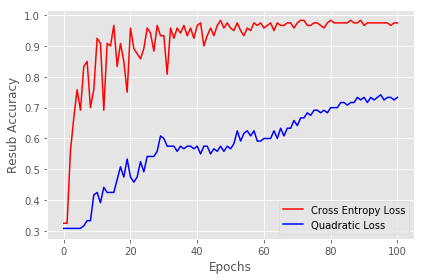

In [1610]:
print_result(nn_mini,X_train1,y_train1,X_test1,y_test1,title="Cross Entropy Loss",color="red")
print_result(nn_mini31,X_train1,y_train1,X_test1,y_test1,title="Quadratic Loss",color="blue")
plt.show()

In [1611]:
%time nn_minilin.fit(X_train1, y_train1, print_progress=10)
%time nn_minilin31.fit(X_train1, y_train1, print_progress=10)

Epoch: 100/100

Wall time: 3.13 s


Epoch: 100/100

Wall time: 2.82 s


In [1612]:
nn_minilin31._initialize_weights()

{'self': <__main__.TLPMiniBatch at 0x19b851f7208>,
 'i': 2,
 'W1_num_elems': 250,
 'W1': array([[-0.52528198,  0.57667387,  0.09405514,  0.70057833, -0.13232704],
        [ 0.53845402,  0.39095168, -0.69920273, -0.09322054,  0.65603701],
        [-0.22447883, -0.98738412,  0.95367611, -0.6498271 ,  0.54359975],
        [ 0.41455258, -0.64441745,  0.34050542, -0.01384445,  0.77395835],
        [ 0.834486  , -0.96598624, -0.56031621, -0.0494715 , -0.76876515],
        [-0.37018428,  0.22826745,  0.38050756, -0.61033626,  0.82751287],
        [-0.92611985, -0.85438555, -0.79676144, -0.74451989,  0.02193732],
        [-0.84857446,  0.84216627,  0.38539388,  0.09549927, -0.82626641],
        [ 0.76317239,  0.45937518, -0.5965044 ,  0.65115764, -0.7463649 ],
        [ 0.32545609, -0.76518558, -0.33451345, -0.11839881,  0.88892346],
        [-0.74702219, -0.36490354, -0.45099775, -0.09425382,  0.80348947],
        [-0.14720755, -0.49635716, -0.15928352, -0.66971856, -0.2844554 ],
        [ 0.

Cross Entropy Loss sig :
Resubstitution acc: 0.975
Validation acc: 0.9666666666666667
Cross Entropy Loss lin :
Resubstitution acc: 0.9833333333333333
Validation acc: 0.9333333333333333


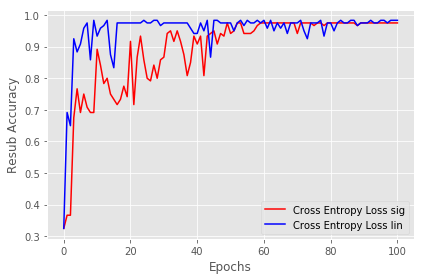

In [1613]:
print_result(nn_minilin,X_train1,y_train1,X_test1,y_test1,title="Cross Entropy Loss sig",color="red")
print_result(nn_minilin31,X_train1,y_train1,X_test1,y_test1,title="Cross Entropy Loss lin",color="blue")
plt.show()

In [1614]:
params2 = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=50, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='relu',n_ner=2,cf='ce')
params3 = dict(n_hidden=50, 
              C=.0001, # tradeoff L2 regularizer
              epochs=50, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              phi='relu',n_ner=3,cf='ce')
nn_mini2 = TLPMiniBatch(**params2,
                          alpha=0.001,# momentum calculation
                          decrease_const=0.0001, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

nn_mini3 = TLPMiniBatch(**params3,
                          alpha=0.001,# momentum calculation
                          decrease_const=1e-5, # decreasing eta
                          minibatches=50, # minibatch size
                          shuffle=True)

In [1615]:
%time nn_mini2.fit(X_train1, y_train1, print_progress=10)
%time nn_mini3.fit(X_train1, y_train1, print_progress=10)

Epoch: 50/50

Wall time: 674 ms


Epoch: 50/50

Wall time: 1.4 s


In [1616]:
nn_mini3._initialize_weights()

{'self': <__main__.TLPMiniBatch at 0x19b90b04cc0>,
 'i': 2,
 'W1_num_elems': 250,
 'W1': array([[-0.59378624,  0.26427625,  0.58857752, -0.65617304, -0.76186009],
        [ 0.01336741, -0.01350805, -0.05311614,  0.18014739, -0.91863128],
        [-0.78432254, -0.06980679, -0.43640901,  0.49217968, -0.19244013],
        [-0.43935974, -0.92850759, -0.13670186,  0.34591299,  0.94209158],
        [-0.00197809,  0.18880135,  0.35357885,  0.90168607, -0.70171316],
        [-0.66106979,  0.4926032 ,  0.99766479,  0.96630682,  0.26208747],
        [ 0.50268681, -0.24179552, -0.2680775 ,  0.57768854,  0.46752702],
        [-0.84318739, -0.37229091,  0.55333102, -0.25493263, -0.25290006],
        [-0.28761829,  0.59346452,  0.11168498, -0.78773367, -0.9995301 ],
        [-0.810147  , -0.90916243,  0.2649441 ,  0.49817284, -0.09996317],
        [-0.68660148, -0.4567871 ,  0.81544601,  0.78561166,  0.48278321],
        [-0.47800501, -0.43292838,  0.65849374,  0.69399648,  0.91025611],
        [-0.

CE sig 2 layers :
Resubstitution acc: 0.9833333333333333
Validation acc: 0.9333333333333333
CE sig 3 layers :
Resubstitution acc: 0.9833333333333333
Validation acc: 0.9666666666666667


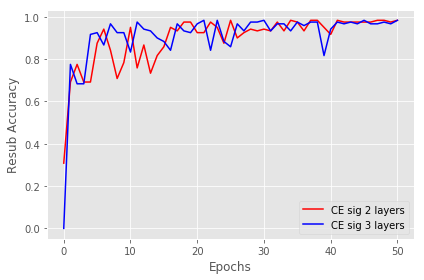

In [1617]:
print_result(nn_mini2,X_train1,y_train1,X_test1,y_test1,title="CE sig 2 layers",color="red")
print_result(nn_mini3,X_train1,y_train1,X_test1,y_test1,title="CE sig 3 layers",color="blue")
plt.show()